# Conexion a google drive

In [1]:
from google.colab  import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/modelos_prediccion_tesis/set_datos/'
!ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/10DH9cK0MxHSHfBHffXMZxnYmmBdGc0_t/modelos_prediccion_tesis/set_datos
entrenamiento_solcast_12h.pdf	      irradiancia_udenar_acondicionada.csv
entrenamiento_solcast_1h.pdf	      model.png
entrenamiento_solcast_1h.svg	      pronostico_solcast_12h.pdf
entrenamiento_solcast_30min.svg       pronostico_solcast_1h.pdf
entrenamiento_solcast_3h.pdf	      pronostico_solcast_1h.svg
entrenamiento_solcast_3h.svg	      pronostico_solcast_30min.svg
entrenamiento_solcast_6h.pdf	      pronostico_solcast_3h.pdf
entrenamiento_solcast_9h.pdf	      pronostico_solcast_3h.svg
entrenamiento_udenar_12h.pdf	      pronostico_solcast_6h.pdf
entrenamiento_udenar_1h.pdf	      pronostico_solcast_9h.pdf
entrenamiento_udenar_3h.pdf	      pronostico_udenar_12h.pdf
entrenamiento_udenar_6h.pdf	      pronostico_udenar_3h.pdf
entrenamiento_udenar_9h.pdf	      pronostico_udenar_6h.pdf
irradiancia_preprocesada_solcast.csv  pronostico_udenar_9h.pdf
irradiancia_p

# Librerias

In [2]:
# Librerias en comun

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.dates as mdates
sns.set_style("whitegrid")

# Librerias de preprocesamiento

import pytz
from datetime import datetime, date

# Librerias pronostico

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, RepeatVector, TimeDistributed, Input
from tensorflow.keras.optimizers import Adam
# from keras.utils.vis_utils import plot_model
import tensorflow as tf
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from keras.callbacks import EarlyStopping
from tensorflow.keras  import optimizers
from IPython.display import display_html # To visualize dataframes side by side
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Para obtener resultados reproducibles

import random
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

## Funciones

In [3]:
# Funcion filtrar serie de tiempo de irrradiancia: Elimina los datos de irradiancia entre 6pm y 6am
def filter_data(df_day):
    mask = np.logical_or.reduce([
        (df_day.index.hour < 6),
        (df_day.index.hour == 6) & (df_day.index.minute < 00),
        (df_day.index.hour > 18),
        (df_day.index.hour == 18) & (df_day.index.minute > 00)
    ])
    df_day.loc[mask, 'ghi'] = np.nan
    return df_day

In [4]:
# Funcion recorte de ventanas delizantes
def split_sequences(features, targets, n_steps_in, n_steps_out, n_sliding_steps, window_type):
    """
    Args:
    * features: Secuencias de entrada que pueden ser univariadas o multvariadas
    * targets: Secuencias de salida que pueden ser univariadas o multvariadas
    * n_steps_in: Longitud de la secuencia de entrada para la ventana deslizante
    * n_steps_out: Longitud de la secuencia de salida.
    * n_sliding_steps: Tamaño del paso de la ventana.
    * window_type: Tipo de ventana 'sliding' or 'expanding'  ('Deslizante o expansiva')
    """
    X, y = list(), list()
    for i in range(0, len(features), n_sliding_steps):

        # Calcula el final de la secuencia en curso
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # Comprueba si el ciclo esta fuera del limite de secuencias
        if out_end_ix > len(features):
            break

        # Recopila las secuencias de entrada y salida del ciclo
        if window_type == 'sliding': # Sliding window
            seq_x, seq_y = features[i:end_ix], targets[end_ix:out_end_ix]
        else: # expanding window
            seq_x, seq_y = features[0:end_ix], targets[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
# Funcion configuracion de parametros para recorte de ventanas deslizante.
def dataset_sel(days,window,future):
  input_seq_length = 144*days # Pasado Historico. Input [5min]
  output_seq_length = future # Futuro de Predicción. Output [5min]
  sliding_steps =  window # Pasos que recorre la ventana deslizante en la serie de tiempo [2min]
  test_index_set = df_cudenar.index
  test_set = test_scal.reshape(-1)
  X_test, y_test = split_sequences(test_set,
                                  test_set,
                                  n_steps_in = input_seq_length,
                                  n_steps_out = output_seq_length,
                                  n_sliding_steps = sliding_steps,
                                  window_type='sliding')

  index_X_test, index_y_test = split_sequences(test_index_set,
                                    test_index_set,
                                    n_steps_in = input_seq_length,
                                    n_steps_out = output_seq_length,
                                    n_sliding_steps = sliding_steps,
                                    window_type='sliding')
  n_features = 1
  X_test = X_test.astype(np.float32).reshape(X_test.shape[0],input_seq_length,n_features)
  y_test = y_test.astype(np.float32)
  return X_test, y_test, index_y_test


In [6]:
# Funcion importar modelos
def model(model_path):
  model = load_model(model_path, compile=False)
  model.summary()
  optimizer = optimizers.Adam(learning_rate=1e-3)
  model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
  print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Modelo cargado <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
  return model

In [7]:
# Funcion metricas que prueban modelos.
def metrics(y_test,y_pred,model):
  mse = mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))
  rmse = np.sqrt(mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1)))
  mae = mean_absolute_error(y_test.reshape(-1), y_pred.reshape(-1))
  mape = mean_absolute_percentage_error(y_test.reshape(-1), y_pred.reshape(-1))
  r2 = r2_score(y_test.reshape(-1), y_pred.reshape(-1))
  return print(f'{model} model metrics:  MSE = {mse: .4f}, RMSE = {rmse: .4f}, mae = {mae: .4f}, mape = {mape: .4f}, R2 = {r2: .4f}.')

In [8]:
# Funcion creacion Dataframes pronósticos
def prediction_dataframe(index,y_test,y_pred):
  df_p = pd.DataFrame(index.reshape(-1),columns=['fecha'])
  df_p['Ghi'] = y_test.reshape(-1)
  df_p['Ghi_p'] = y_pred.reshape(-1)
  df_p = df_p.groupby('fecha').sum()
  df_p = df_p.resample(pd.Timedelta('5min')).asfreq(fill_value=0)
  df_p.reset_index(inplace=True)
  return df_p

# Lectura de datos

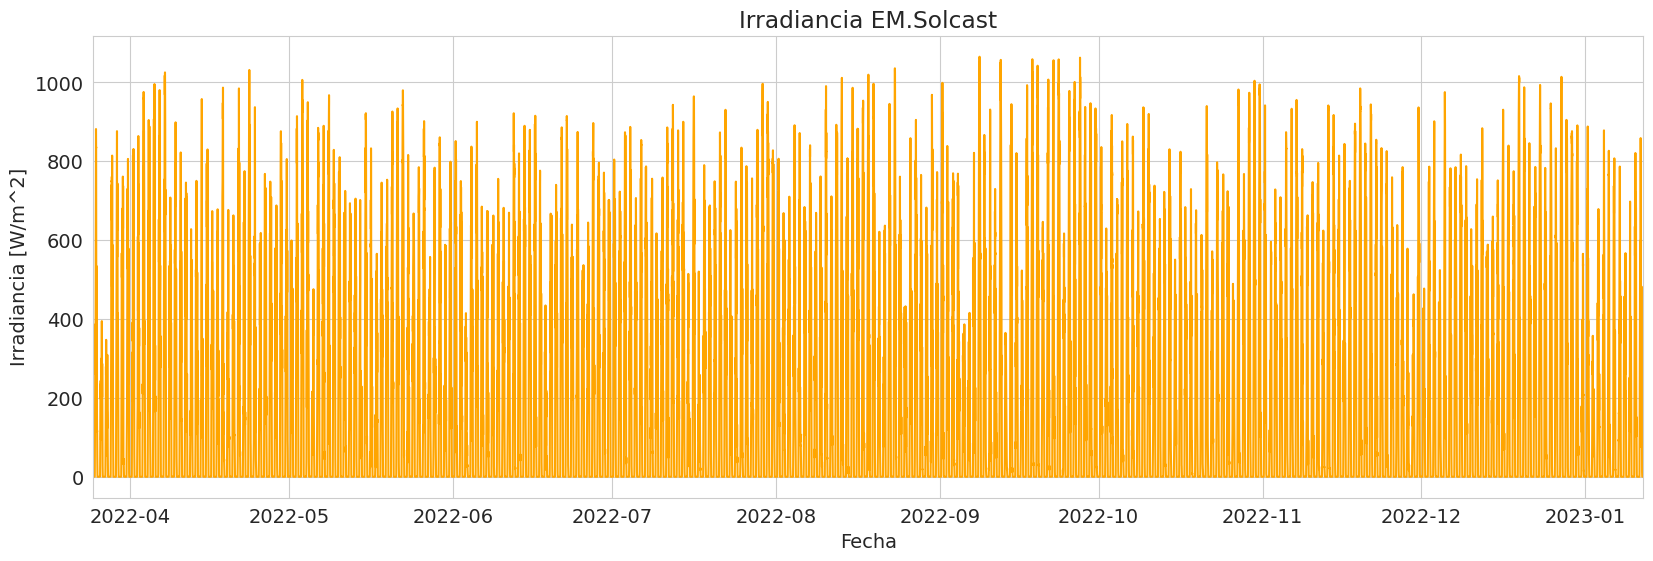

In [9]:
# Lectura de datos
df = pd.read_csv('irradiancia_preprocesada_solcast.csv')
df.index = pd.to_datetime(df['fecha'])
del(df['fecha'])

# Visualizacion de datos

plt.figure(figsize=(20,6))
plt.plot(df,'orange')
plt.xlim([df.index[0], df.index[-1]])
plt.xlabel('Fecha')
plt.ylabel('Irradiancia [W/m^2]')
plt.title('Irradiancia EM.Solcast')
plt.show()

# Parte 1: Acondicionamiento de datos

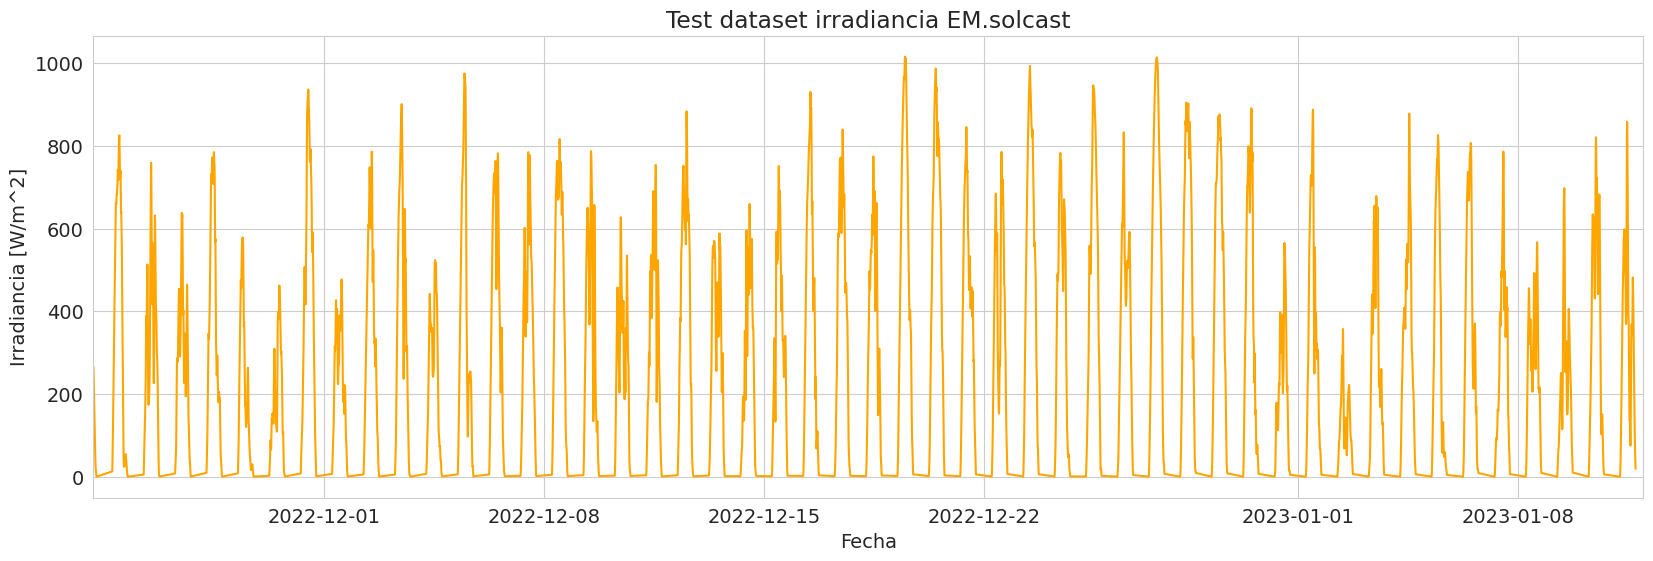

In [10]:
dfu = df.copy()
dfu = dfu.loc[datetime(2022,11,23,15,36,0) : datetime(2023,1,12)].groupby(pd.Grouper(freq='D'), group_keys=False).apply(filter_data) #14
dfu = dfu.dropna()

# Grafica irradiancia acondicionada

plt.figure(figsize=(20,6))
plt.plot(dfu,'orange')
plt.xlabel('Fecha')
plt.ylabel('Irradiancia [W/m^2]')
plt.title('Test dataset irradiancia EM.solcast')
plt.xlim([datetime(2022,11,23,15,36,0)  , datetime(2023,1,12)])
plt.show()

In [11]:
dfu.values.dtype

dtype('float64')

In [12]:
print(f'Cantidad de datos de irradiancia: {dfu.shape[0]}')
print(f'Tipo de datos: {(dfu).values.dtype}')
print('-------------------------Datos duplicados-----------------------------------------')
print('Cantidad de datos duplicados: ' + str(dfu.index.duplicated().sum()))
print('-------------------------Datos nulos----------------------------------------------')
print('Cantidad de datos Nulos: ' + str(dfu.isnull().sum().sum()))
print('-------------------------Propiedades estadistcas----------------------------------')
dfu.describe()

Cantidad de datos de irradiancia: 7134
Tipo de datos: float64
-------------------------Datos duplicados-----------------------------------------
Cantidad de datos duplicados: 0
-------------------------Datos nulos----------------------------------------------
Cantidad de datos Nulos: 0
-------------------------Propiedades estadistcas----------------------------------


,ghi
count,7134.000000
mean,375.147855
std,263.808817
min,0.000000
25%,142.600000
50%,349.600000
75%,580.550000
max,1016.000000


## Normalización

Copia dataframe udenar

In [13]:
df_cudenar = dfu.copy()
scaler_test =  MinMaxScaler(feature_range=(-1, 1))
scaler_test.fit_transform(df_cudenar);
test_scal = scaler_test.transform(df_cudenar)

# Parte 2 : Pronóstico




## Modelos

In [14]:
model_1 = model('/content/drive/My Drive/modelos_prediccion_tesis/modelos_solcast/modelos_lstm/modelos_almacenados/solcast_lstm_6h_kfold_model.h5')
model_2 = model('/content/drive/My Drive/modelos_prediccion_tesis/modelos_solcast/modelos_gru/modelos_almacenados/solcast_gru_6h_kfold_model.h5')
model_3 = model('/content/drive/My Drive/modelos_prediccion_tesis/modelos_solcast/modelos_cnnd/modelos_almacenados/cnnd_6h_solcast_kfold_model.h5')
model_4 = model('/content/drive/My Drive/modelos_prediccion_tesis/modelos_solcast/modelos_cnn_lstm/modelos_almacenados/cnn_lstm_6h_solcast_kfold_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_encoder (LSTM)         (None, 128)               66560     
                                                                 
 repeat_vector (RepeatVecto  (None, 72, 128)           0         
 r)                                                              
                                                                 
 LSTM_decoder (LSTM)         (None, 72, 128)           131584    
                                                                 
 Salida (TimeDistributed)    (None, 72, 1)             129       
                                                                 
Total params: 198273 (774.50 KB)
Trainable params: 198273 (774.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Modelo cargado <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

In [15]:
X_test_m1,y_test_m1,index_y_test_m1 = dataset_sel(7,72,72)
X_test_m2,y_test_m2,index_y_test_m2 = dataset_sel(7,72,72)
X_test_m3,y_test_m3,index_y_test_m3 = dataset_sel(7,72,72)
X_test_m4,y_test_m4,index_y_test_m4 = dataset_sel(7,72,72)


In [16]:
y1n_pred = model_1.predict(X_test_m1, verbose=0)
y2n_pred = model_2.predict(X_test_m2, verbose=0)
y3n_pred = model_3.predict(X_test_m3, verbose=0)
y4n_pred = model_4.predict(X_test_m4, verbose=0)

y1n_pred = scaler_test.inverse_transform(y1n_pred.reshape(y1n_pred.shape[0],y1n_pred.shape[1]))
y2n_pred = scaler_test.inverse_transform(y2n_pred.reshape(y2n_pred.shape[0],y2n_pred.shape[1]))
y3n_pred = scaler_test.inverse_transform(y3n_pred.reshape(y3n_pred.shape[0],y3n_pred.shape[1]))
y4n_pred = scaler_test.inverse_transform(y4n_pred.reshape(y4n_pred.shape[0],y4n_pred.shape[1]))

X_test_m1 = scaler_test.inverse_transform(X_test_m1.reshape(X_test_m1.shape[0],X_test_m1.shape[1]))
y_test_m1 = scaler_test.inverse_transform(y_test_m1.reshape(y_test_m1.shape[0],y_test_m1.shape[1]))
X_test_m2 = scaler_test.inverse_transform(X_test_m2.reshape(X_test_m2.shape[0],X_test_m2.shape[1]))
y_test_m2 = scaler_test.inverse_transform(y_test_m2.reshape(y_test_m2.shape[0],y_test_m2.shape[1]))
X_test_m3 = scaler_test.inverse_transform(X_test_m3.reshape(X_test_m3.shape[0],X_test_m3.shape[1]))
y_test_m3 = scaler_test.inverse_transform(y_test_m3.reshape(y_test_m3.shape[0],y_test_m3.shape[1]))
X_test_m4 = scaler_test.inverse_transform(X_test_m4.reshape(X_test_m4.shape[0],X_test_m4.shape[1]))
y_test_m4 = scaler_test.inverse_transform(y_test_m4.reshape(y_test_m4.shape[0],y_test_m4.shape[1]))

## Metricas Modelos


In [17]:
metrics(y_test_m1,y1n_pred,'LSTM')
metrics(y_test_m2,y2n_pred,'GRU')
metrics(y_test_m3,y3n_pred,'CNN-D')
metrics(y_test_m4,y4n_pred,'CNN-LSTM')

LSTM model metrics:  MSE =  24589.0273, RMSE =  156.8089, mae =  119.7258, mape =  931869726081024.0000, R2 =  0.6502.
GRU model metrics:  MSE =  24838.0645, RMSE =  157.6010, mae =  119.2517, mape =  446387762233344.0000, R2 =  0.6467.
CNN-D model metrics:  MSE =  25856.7891, RMSE =  160.8005, mae =  122.0850, mape =  819317088190464.0000, R2 =  0.6322.
CNN-LSTM model metrics:  MSE =  25561.9277, RMSE =  159.8810, mae =  120.7758, mape =  579710325096448.0000, R2 =  0.6364.


Graficas predicciones

In [18]:
df_p1 = prediction_dataframe(index_y_test_m1,y_test_m1,y1n_pred)
df_p2 = prediction_dataframe(index_y_test_m2,y_test_m2,y2n_pred)
df_p3 = prediction_dataframe(index_y_test_m3,y_test_m3,y3n_pred)
df_p4 = prediction_dataframe(index_y_test_m4,y_test_m4,y4n_pred)

In [19]:
sample = 2430 # Indice de Muestra a graficar
freq = '12h' # Frecuencia de divisiones en el eje de tiempo
width = 6 # Ancho de grafica
height = 5 # Alto de grafica

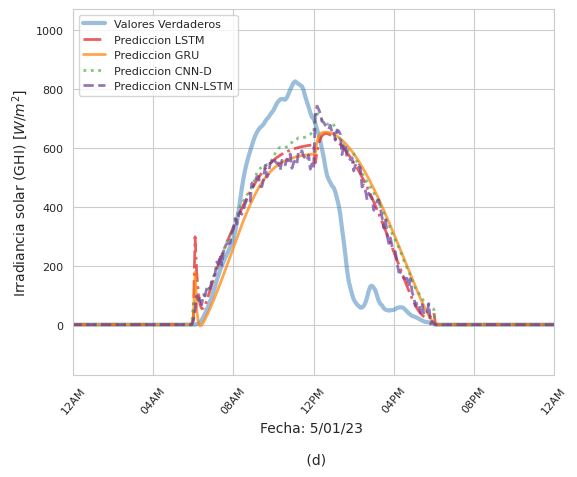

In [20]:
fig, ax=plt.subplots(1,1,figsize=(width, height))
fig.patch.set_facecolor('white')
ax.set_ylabel('Irradiancia solar (GHI) [$W/m^2$]', fontsize= 10)
ax.set_xlabel('Fecha: 5/01/23 ' + '\n \n (d)', fontsize= 10)
sns.lineplot(x=pd.to_datetime(df_p1['fecha']), y=df_p1['Ghi'], ax=ax, color='#377eb8', label='Valores Verdaderos', linestyle='-',alpha=0.5,linewidth=3)
sns.lineplot(x=pd.to_datetime(df_p1['fecha']), y=df_p1['Ghi_p'], ax=ax, color='#e31a1c', label='Prediccion LSTM', linestyle='-.',alpha=0.7,linewidth=2)
sns.lineplot(x=pd.to_datetime(df_p2['fecha']), y=df_p2['Ghi_p'], ax=ax, color='#ff7f00', label='Prediccion GRU', linestyle='-',alpha=0.7,linewidth=2)
sns.lineplot(x=pd.to_datetime(df_p3['fecha']), y=df_p3['Ghi_p'], ax=ax, color='#4daf4a', label='Prediccion CNN-D', linestyle=':',alpha=0.7,linewidth=2)
sns.lineplot(x=pd.to_datetime(df_p4['fecha']), y=df_p4['Ghi_p'], ax=ax, color='#6a3d9a', label='Prediccion CNN-LSTM', linestyle='--',alpha=0.7,linewidth=2)

ax.set_xlim([date(2023, 1, 5), date(2023, 1, 6)])
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
myFmt = mdates.DateFormatter('%I%p')
ax.xaxis.set_major_formatter(myFmt)
plt.xticks(rotation=50)

plt.legend(loc=2, fontsize= 8)
plt.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig("pronostico_solcast_6h.svg", format="svg")
plt.show();

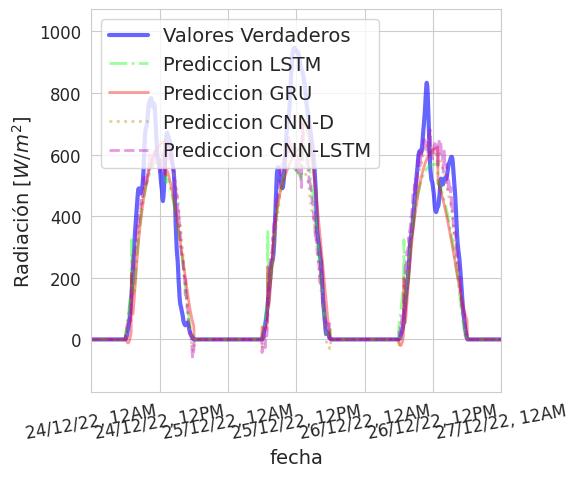

In [21]:
fig, ax=plt.subplots(1,1,figsize=(width, height))
fig.patch.set_facecolor('white')
ax.set_ylabel('Radiación [$W/m^2$]')
sns.lineplot(x=pd.to_datetime(df_p1['fecha']), y=df_p1['Ghi'], ax=ax, color='b', label='Valores Verdaderos', linestyle='-',alpha=0.6,linewidth=3)
sns.lineplot(x=pd.to_datetime(df_p1['fecha']), y=df_p1['Ghi_p'], ax=ax, color='#00FF00', label='Prediccion LSTM', linestyle='-.',alpha=0.4,linewidth=2)
sns.lineplot(x=pd.to_datetime(df_p2['fecha']), y=df_p2['Ghi_p'], ax=ax, color='r', label='Prediccion GRU', linestyle='-',alpha=0.4,linewidth=2)
sns.lineplot(x=pd.to_datetime(df_p3['fecha']), y=df_p3['Ghi_p'], ax=ax, color='#B8860B', label='Prediccion CNN-D', linestyle=':',alpha=0.4,linewidth=2)
sns.lineplot(x=pd.to_datetime(df_p4['fecha']), y=df_p4['Ghi_p'], ax=ax, color='m', label='Prediccion CNN-LSTM', linestyle='--',alpha=0.4,linewidth=2)

ax.set_xlim([date(2022, 12, 24), date(2022, 12, 27)])
myFmt = mdates.DateFormatter('%d/%m/%y, %I%p')
ax.xaxis.set_major_formatter(myFmt)
plt.xticks(rotation=10)

plt.legend(loc=2)
plt.tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('division.jpg', dpi=300, bbox_inches='tight')
plt.show();

In [22]:
import plotly.express as px
import plotly.graph_objects as go

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pd.to_datetime(df_p1['fecha']), y=df_p1['Ghi'],name='Valores Verdaderos'))
fig.add_trace(go.Scatter(x=pd.to_datetime(df_p1['fecha']), y=df_p1['Ghi_p'],name='LSTM',opacity=0.7,line = dict(dash = 'dot')))   # Curva predicciones LSTM
fig.add_trace(go.Scatter(x=pd.to_datetime(df_p2['fecha']), y=df_p2['Ghi_p'],name='GRU',opacity=0.7,line = dict(dash = 'dot')))    # Curva predicciones GRU
fig.add_trace(go.Scatter(x=pd.to_datetime(df_p3['fecha']), y=df_p3['Ghi_p'],name='CNN-D',opacity=0.7,line = dict(dash = 'dot')))  # Curva predicciones CNN-D
fig.add_trace(go.Scatter(x=pd.to_datetime(df_p4['fecha']), y=df_p4['Ghi_p'],name='CNN-LSTM',opacity=0.7,line = dict(dash = 'dot'))) # Curva predicciones CNN-LSTM
fig.update_xaxes(range=[date(2022, 12, 24), date(2022, 12, 27)],showline=True, linewidth=2, linecolor='lightgrey', mirror=True,showgrid=True, gridwidth=1, gridcolor='lightgrey')  # Configuraciones eje X / Rango / lineas limites / color lineas grid horizontal
fig.update_yaxes(showline=True, linewidth=2, linecolor='lightgrey', mirror=True,showgrid=True, gridwidth=1, gridcolor='lightgrey') # Configuraciones eje Y / lineas limites / color lineas grid horizontal
fig.update_layout(              # Configuraciones Generales
    autosize=False,             # Autotamaño desactivado
    width=1000,                 # Ancho de imagen
    height=1000,                 # Alto de imagen
    template = 'plotly_white',  # Color del fondo
    title={'text':r'$\text{Predicciones } 3h \text{ EM. Solcast}$','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},   # Titulo y configuraciones de posicion
    xaxis_title=r'$Fecha$',                                                                                                 # Etiqueta eje X
    yaxis_title=r'$Irradiancia [W/m^{2}]$',                                                                                 # Etiqueta eje Y
    font = dict(size=15),                                                                                                   # Tamaño elementos ejes
    title_font=dict(size=50),                                                                                               # Tamaño titulo
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01, font=dict(size= 20))                                         # Tamaño leyenda
    )
fig.show()

Output hidden; open in https://colab.research.google.com to view.

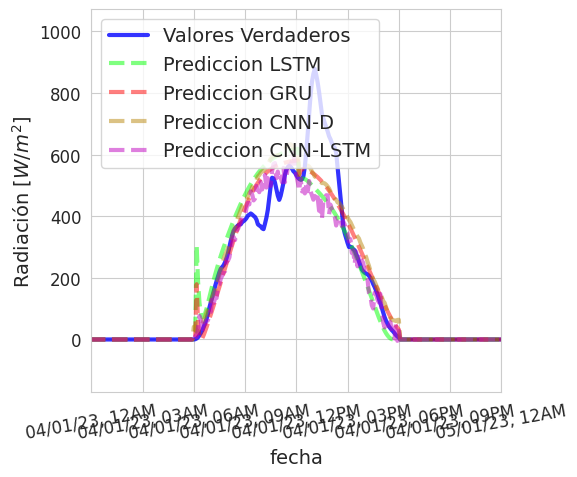

In [24]:
fig, ax=plt.subplots(1,1,figsize=(width, height))
fig.patch.set_facecolor('white')
ax.set_ylabel('Radiación [$W/m^2$]')
sns.lineplot(x=pd.to_datetime(df_p1['fecha']), y=df_p1['Ghi'], ax=ax, color='b', label='Valores Verdaderos', linestyle='-',alpha=0.8,linewidth=3)
sns.lineplot(x=pd.to_datetime(df_p1['fecha']), y=df_p1['Ghi_p'], ax=ax, color='#00FF00', label='Prediccion LSTM', linestyle='--',alpha=0.5,linewidth=3)
sns.lineplot(x=pd.to_datetime(df_p2['fecha']), y=df_p2['Ghi_p'], ax=ax, color='r', label='Prediccion GRU', linestyle='--',alpha=0.5,linewidth=3)
sns.lineplot(x=pd.to_datetime(df_p3['fecha']), y=df_p3['Ghi_p'], ax=ax, color='#B8860B', label='Prediccion CNN-D', linestyle='--',alpha=0.5,linewidth=3)
sns.lineplot(x=pd.to_datetime(df_p4['fecha']), y=df_p4['Ghi_p'], ax=ax, color='m', label='Prediccion CNN-LSTM', linestyle='--',alpha=0.5,linewidth=3)


ax.set_xlim([date(2023, 1, 4), date(2023, 1, 5)])
myFmt = mdates.DateFormatter('%d/%m/%y, %I%p')
ax.xaxis.set_major_formatter(myFmt)
plt.xticks(rotation=10)

plt.legend(loc=2)
plt.tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('division.jpg', dpi=300, bbox_inches='tight')
plt.show();

In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pd.to_datetime(df_p1['fecha']), y=df_p1['Ghi'],name='Valores Verdaderos'))
fig.add_trace(go.Scatter(x=pd.to_datetime(df_p1['fecha']), y=df_p1['Ghi_p'],name='LSTM',opacity=0.7,line = dict(dash = 'dot')))   # Curva predicciones LSTM
fig.add_trace(go.Scatter(x=pd.to_datetime(df_p2['fecha']), y=df_p2['Ghi_p'],name='GRU',opacity=0.7,line = dict(dash = 'dot')))    # Curva predicciones GRU
fig.add_trace(go.Scatter(x=pd.to_datetime(df_p3['fecha']), y=df_p3['Ghi_p'],name='CNN-D',opacity=0.7,line = dict(dash = 'dot')))  # Curva predicciones CNN-D
fig.add_trace(go.Scatter(x=pd.to_datetime(df_p4['fecha']), y=df_p4['Ghi_p'],name='CNN-LSTM',opacity=0.7,line = dict(dash = 'dot'))) # Curva predicciones CNN-LSTM
fig.update_xaxes(range=[date(2023, 1, 4), date(2023, 1, 5)],showline=True, linewidth=2, linecolor='lightgrey', mirror=True,showgrid=True, gridwidth=1, gridcolor='lightgrey')  # Configuraciones eje X / Rango / lineas limites / color lineas grid horizontal
fig.update_yaxes(showline=True, linewidth=2, linecolor='lightgrey', mirror=True,showgrid=True, gridwidth=1, gridcolor='lightgrey') # Configuraciones eje Y / lineas limites / color lineas grid horizontal
fig.update_layout(              # Configuraciones Generales
    autosize=False,             # Autotamaño desactivado
    width=1000,                 # Ancho de imagen
    height=800,                 # Alto de imagen
    template = 'plotly_white',  # Color del fondo
    title={'text':r'$\text{Predicciones } 1h \text{ EM. Solcast}$','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'},   # Titulo y configuraciones de posicion
    xaxis_title=r'$Fecha$',                                                                                                 # Etiqueta eje X
    yaxis_title=r'$Irradiancia [W/m^{2}]$',                                                                                 # Etiqueta eje Y
    font = dict(size=15),                                                                                                   # Tamaño elementos ejes
    title_font=dict(size=50),                                                                                               # Tamaño titulo
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01, font=dict(size= 20))                                         # Tamaño leyenda
    )
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## Graficas perdidas


In [26]:
loss_lstm = pd.read_csv('/content/drive/My Drive/modelos_prediccion_tesis/modelos_solcast/modelos_lstm/modelos_almacenados/solcast_lstm_6h_kfold_metricas.csv')
loss_gru = pd.read_csv('/content/drive/My Drive/modelos_prediccion_tesis/modelos_solcast/modelos_gru/modelos_almacenados/solcast_gru_6h_kfold_metricas.csv')
loss_cnnd = pd.read_csv('/content/drive/My Drive/modelos_prediccion_tesis/modelos_solcast/modelos_cnnd/modelos_almacenados/solcast_cnnd_6h_kfold_metricas.csv')
loss_cnn_lstm = pd.read_csv('/content/drive/My Drive/modelos_prediccion_tesis/modelos_solcast/modelos_cnn_lstm/modelos_almacenados/solcast_cnn_lstm_6h_kfold_metricas.csv')

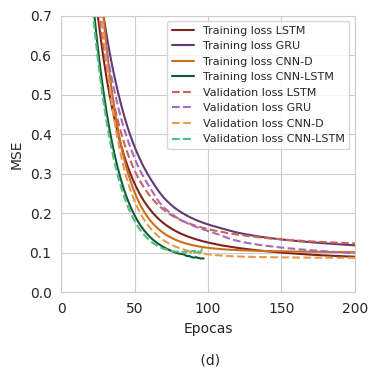

In [27]:
#Epochs

epochs_lstm = np.arange(1,len(loss_lstm.index)+1)
epochs_gru = np.arange(1,len(loss_gru.index)+1)
epochs_cnnd = np.arange(1,len(loss_cnnd.index)+1)
epochs_cnn_lstm = np.arange(1,len(loss_cnn_lstm.index)+1)

#MSE
fig, (ax) = plt.subplots(1,1,figsize=(4,4))
fig.patch.set_facecolor('white')
ax.plot(epochs_lstm, loss_lstm['loss'], color = '#7B241C', label='Training loss LSTM')
ax.plot(epochs_gru, loss_gru['loss'], color = '#633974', label='Training loss GRU')
ax.plot(epochs_cnnd, loss_cnnd['loss'], color = '#CA6F1E', label='Training loss CNN-D')
ax.plot(epochs_cnn_lstm, loss_cnn_lstm['loss'], color = '#145A32', label='Training loss CNN-LSTM')
ax.plot(epochs_lstm, loss_lstm['val_loss'], color =  '#CD6155', label='Validation loss LSTM',linestyle='dashed')
ax.plot(epochs_gru, loss_gru['val_loss'], color =  '#A569BD', label='Validation loss GRU',linestyle='dashed')
ax.plot(epochs_cnnd, loss_cnnd['val_loss'], color =  '#EB984E', label='Validation loss CNN-D',linestyle='dashed')
ax.plot(epochs_cnn_lstm, loss_cnn_lstm['val_loss'], color =  '#52BE80', label='Validation loss CNN-LSTM',linestyle='dashed')
ax.set_xlabel('Epocas' + '\n \n (d)', fontsize = 10)
ax.set_ylabel('MSE', fontsize = 10)
ax.legend(loc=1,fontsize=8)
ax.set_ylim([0 , 0.7])
ax.set_xlim([0, 200])
## RMSE


# ax1.plot(epochs_lstm, loss_lstm['mae'], color = '#7B241C', label='Training RMSE LSTM')
# ax1.plot(epochs_gru, loss_gru['mae'], color = '#633974', label='Training RMSE GRU')
# ax1.plot(epochs_cnnd, loss_cnnd['mae'], color = '#CA6F1E', label='Training RMSE CNN-D')
# ax1.plot(epochs_cnn_lstm, loss_cnn_lstm['mae'], color = '#145A32', label='Training RMSE CNN-LSTM')
# ax1.plot(epochs_lstm, loss_lstm['val_mae'], color =  '#CD6155', label='Validation RMSE LSTM',linestyle='dashed')
# ax1.plot(epochs_gru, loss_gru['val_mae'], color =  '#A569BD', label='Validation RMSE GRU',linestyle='dashed')
# ax1.plot(epochs_cnnd, loss_cnnd['val_mae'], color =  '#EB984E', label='Validation RMSE CNN-D',linestyle='dashed')
# ax1.plot(epochs_cnn_lstm, loss_cnn_lstm['val_mae'], color =  '#52BE80', label='Validation RMSE CNN-LSTM',linestyle='dashed')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('MAE')
# ax1.legend(loc=1)
# ax1.set_ylim([0 , 0.7])


plt.tick_params(labelsize=10)
# fig.suptitle('Curva de aprendizaje entrenamiento y validacion EM. UDENAR 30min',fontsize=12)
plt.tight_layout()
plt.savefig("entrenamiento_solcast_6h.svg", format="svg")

plt.show();

# Almacenar mejor modelo de pronóstico

In [28]:
# df_p = pd.DataFrame(index_y_test.reshape(-1),columns=['Fecha'])
# df_p['Ghi'] = yn_test.reshape(-1)
# df_p['Ghi_p1'] = y1n_pred.reshape(-1)

In [29]:
# # dura donde se almacenara el archivo
# dir_pandas = '/content/drive/My Drive/modelos_de_pronostico/series_kalman/series_udenar/series_1h_selec/{}'
# dir_pandas

In [30]:
# df_p.to_csv(dir_pandas.format('irrad_udenar_lstm_1h.csv'),index=False)